In [1]:

import pandas as pd
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [2]:

# Загрузка CSV
nodes_df = pd.read_csv("data/cert4.2/out/nodes.csv", index_col=0)
resources_df = pd.read_csv("data/cert4.2/out/resources.csv")
edges_df = pd.read_csv("data/cert4.2/out/edges.csv")

# Кодировка ID
user_encoder = LabelEncoder()
resource_encoder = LabelEncoder()
nodes_df['encoded_id'] = user_encoder.fit_transform(nodes_df.index)
resources_df['encoded_id'] = resource_encoder.fit_transform(resources_df['resource_id'])

# Признаки
user_features = torch.tensor(nodes_df.drop(columns=['user', 'employee_name'], errors='ignore').values, dtype=torch.float)
resource_features = torch.zeros((len(resources_df), user_features.shape[1]))  # padding
x = torch.cat([user_features, resource_features], dim=0)

# Ребра
edges_df['source_encoded'] = user_encoder.transform(edges_df['source_user'])
edges_df['target_encoded'] = resource_encoder.transform(edges_df['target_resource']) + len(nodes_df)
edge_index = torch.tensor(edges_df[['source_encoded', 'target_encoded']].values.T, dtype=torch.long)

# Метки
y_raw = (nodes_df['login_count'] > nodes_df['login_count'].median()).astype(int)
y = torch.cat([torch.tensor(y_raw.values, dtype=torch.long), torch.full((len(resources_df),), -1, dtype=torch.long)])

train_mask = torch.zeros(x.shape[0], dtype=torch.bool)
train_mask[:len(nodes_df)] = True

data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask)


In [3]:

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x


In [4]:

model = GCN(data.num_features, 16, 2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

losses = []
accuracies = []

for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    model.eval()
    _, pred = out.max(dim=1)
    correct = int((pred[data.train_mask] == data.y[data.train_mask]).sum())
    acc = correct / int(data.train_mask.sum())
    accuracies.append(acc)
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")


Epoch 010, Loss: 3.0493, Accuracy: 0.5680
Epoch 020, Loss: 1.1643, Accuracy: 0.7910
Epoch 030, Loss: 0.6658, Accuracy: 0.7960
Epoch 040, Loss: 0.4478, Accuracy: 0.8580
Epoch 050, Loss: 0.3764, Accuracy: 0.8680
Epoch 060, Loss: 0.3241, Accuracy: 0.8800
Epoch 070, Loss: 0.2872, Accuracy: 0.8980
Epoch 080, Loss: 0.2582, Accuracy: 0.9040
Epoch 090, Loss: 0.2375, Accuracy: 0.9120
Epoch 100, Loss: 0.2250, Accuracy: 0.9210


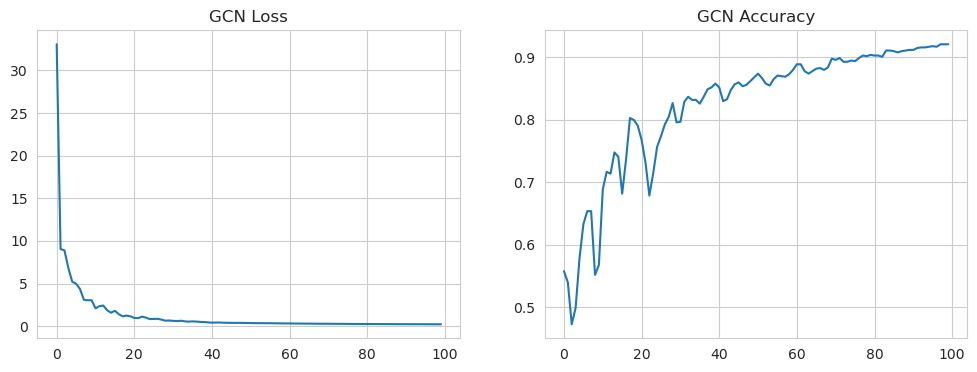

In [5]:

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title("GCN Loss")

plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.title("GCN Accuracy")
plt.show()


In [6]:

from torch import nn


In [7]:

class GCN_LSTM(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, lstm_hidden, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.lstm = nn.LSTM(hidden_channels, lstm_hidden, batch_first=True)
        self.lin = nn.Linear(lstm_hidden, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))         # [N, H]
        x_seq = x.unsqueeze(1)                        # [N, 1, H]
        lstm_out, _ = self.lstm(x_seq)                # [N, 1, H]
        out = self.lin(lstm_out[:, -1, :])            # [N, C]
        return out


In [8]:

model_lstm = GCN_LSTM(data.num_features, 16, 8, 2)
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

losses_lstm = []
accuracies_lstm = []

for epoch in range(1, 101):
    model_lstm.train()
    optimizer_lstm.zero_grad()
    out = model_lstm(data)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer_lstm.step()
    losses_lstm.append(loss.item())

    model_lstm.eval()
    _, pred = out.max(dim=1)
    correct = int((pred[data.train_mask] == data.y[data.train_mask]).sum())
    acc = correct / int(data.train_mask.sum())
    accuracies_lstm.append(acc)
    if epoch % 10 == 0:
        print(f"[GCN+LSTM] Epoch {epoch:03d}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")


[GCN+LSTM] Epoch 010, Loss: 0.6501, Accuracy: 0.6830
[GCN+LSTM] Epoch 020, Loss: 0.5994, Accuracy: 0.6900
[GCN+LSTM] Epoch 030, Loss: 0.5194, Accuracy: 0.7750
[GCN+LSTM] Epoch 040, Loss: 0.4239, Accuracy: 0.8480
[GCN+LSTM] Epoch 050, Loss: 0.3681, Accuracy: 0.8800
[GCN+LSTM] Epoch 060, Loss: 0.3179, Accuracy: 0.9020
[GCN+LSTM] Epoch 070, Loss: 0.2835, Accuracy: 0.9060
[GCN+LSTM] Epoch 080, Loss: 0.2674, Accuracy: 0.9180
[GCN+LSTM] Epoch 090, Loss: 0.2435, Accuracy: 0.9220
[GCN+LSTM] Epoch 100, Loss: 0.2077, Accuracy: 0.9290


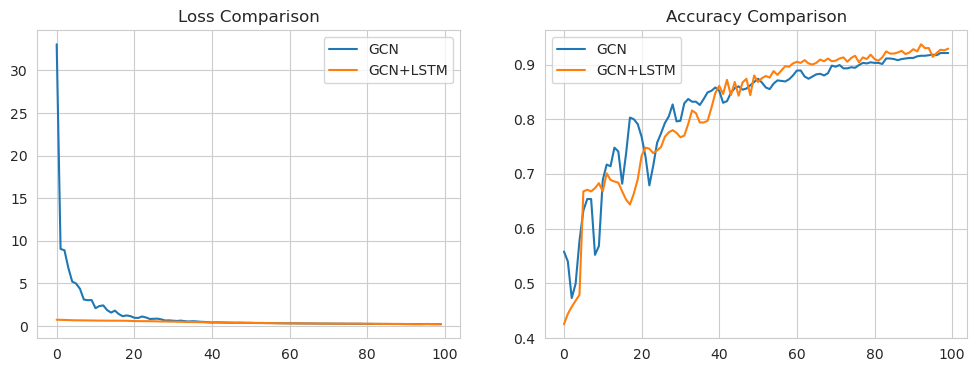

In [9]:

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses, label="GCN")
plt.plot(losses_lstm, label="GCN+LSTM")
plt.title("Loss Comparison")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label="GCN")
plt.plot(accuracies_lstm, label="GCN+LSTM")
plt.title("Accuracy Comparison")
plt.legend()

plt.show()
